In [9]:
"""
Acknowledgements:
1. We referenced the skeleton code of Assignment 7, the original SAC paper (Haarnoja et. al., 2018, https://arxiv.org/abs/1812.05905), 
and the PyTorch implementation of Discor (https://github.com/toshikwa/discor.pytorch) to implement the SAC algorithm.
2. We referenced the original BRO paper (Nauman et. al., 2024, https://arxiv.org/abs/2405.16158), its jax implementation 
(https://github.com/naumix/BiggerRegularizedOptimistic), and its PyTorch implementation (https://github.com/naumix/BiggerRegularizedOtimistic_Torch)
to build upon our SAC implementation and implement the BRO algorithm. 
We also note that the authors' PyTorch implementation of BRO is not coherent with the original paper or its jax implementation, 
but is rather an over-simplified version of the jax implementation.
3. We did NOT directly use the aforementioned open-sourced implementations of SAC and BRO for our implementation,
although they provided us with insights and hints for debugging purposes. 
We implemented the neural network classes and the update function ourself.
"""

"\nAcknowledgements:\n1. We referenced the skeleton code of Assignment 7, the original SAC paper (Haarnoja et. al., 2018, https://arxiv.org/abs/1812.05905), \nand the PyTorch implementation of Discor (https://github.com/toshikwa/discor.pytorch) to implement the SAC algorithm.\n2. We referenced the original BRO paper (Nauman et. al., 2024, https://arxiv.org/abs/2405.16158), its jax implementation \n(https://github.com/naumix/BiggerRegularizedOptimistic), and its PyTorch implementation (https://github.com/naumix/BiggerRegularizedOtimistic_Torch)\nto build upon our SAC implementation and implement the BRO algorithm. \nWe also note that the authors' PyTorch implementation of BRO is not coherent with the original paper or its jax implementation, \nbut is rather an over-simplified version of the jax implementation.\n3. We did NOT directly use the aforementioned open-sourced implementations of SAC and BRO for our implementation,\nalthough they provided us with insights and hints for debugging

In [22]:
pip install --upgrade "gymnasium[mujoco]" torch torchvision torchaudio tqdm matplotlib "gymnasium[other]"

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os, math, random, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.distributions import Normal
import gymnasium as gym
from tqdm.auto import trange
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------  EXPERIMENT  SWITCH-BOARD  ------------------
LARGE_SCALE   = False
USE_CDQ       = True
REPLAY_RATIO  = 1
DUAL_ACTORS   = False
USE_QUANTILE  = False
USE_WD        = False
HARD_RESET    = False
# ---------------------------------------------------------------

# ------------ reproducibility ------------
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('is_available:', torch.cuda.is_available())
print('PyTorch built for CUDA', torch.version.cuda)
if torch.cuda.is_available():
    print('runtime driver version', torch.cuda.get_device_properties(0).major,
          '.', torch.cuda.get_device_properties(0).minor, sep='')
    print('device:', torch.cuda.get_device_name(0))

# ------------ environment ---------------
ENV_ID = "Ant-v5"
env    = gym.make(ENV_ID); env.reset(seed=SEED)
OBS_DIM = env.observation_space.shape[0]
ACT_DIM = env.action_space.shape[0]
ACT_MAX = float(env.action_space.high[0])

is_available: True
PyTorch built for CUDA 12.6
runtime driver version8.9
device: NVIDIA GeForce RTX 4080 SUPER


In [24]:
CRITIC_WID, CRITIC_DEPTH = 512, 3
ACTOR_WID, ACTOR_DEPTH = 256, 2
CRITIC_MLP_WID           = 256
ACTOR_MLP_WID           = 256
N_QUANT           = 100 if USE_QUANTILE else 1
BATCH             = 128
UTD               = REPLAY_RATIO
LR                = 3e-4
TAU               = 0.005
GAMMA             = 0.99
LOG_STD_MIN, LOG_STD_MAX = -5, 2
TARGET_ENT        = -ACT_DIM/2
WD_COEFF          = 1e-4 if USE_WD else 0.0
GRAD_CLIP         = 10.0
RESET_EVERY       = 50_000
TOTAL_STEPS       = 500_000
EVAL_EVERY        = 5_000
START_RANDOM      = 2_500
EVAL_EPISODES     = 50
KAPPA             = 1.0
ALPHA_INIT        = 1.0

def mlp(in_dim, out_dim, hidden=128):
    return nn.Sequential(nn.Linear(in_dim, hidden), nn.ReLU(),
                         nn.Linear(hidden, hidden), nn.ReLU(),
                         nn.Linear(hidden, out_dim))

# residual block used by BRO
class Residual(nn.Module):
    def __init__(self, width: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(width, width, bias=True),
            nn.LayerNorm(width),
            nn.ReLU(inplace=True),
            nn.Linear(width, width, bias=True),
            nn.LayerNorm(width)
        )
    def forward(self, x):
        return x + self.block(x)

# large BRO critic with quantile head
class BroCriticLarge(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.inp = nn.Sequential(
            nn.Linear(obs_dim + act_dim, CRITIC_WID),
            nn.LayerNorm(CRITIC_WID),
            nn.ReLU(inplace=True)
        )
        self.body = nn.Sequential(*[Residual(CRITIC_WID) for _ in range(CRITIC_DEPTH - 1)])
        self.out  = nn.Linear(CRITIC_WID, N_QUANT)
        taus = (torch.arange(N_QUANT)+0.5)/N_QUANT
        self.register_buffer("taus", taus.view(1,N_QUANT))
    def forward(self,s,a):
        h = self.inp(torch.cat([s, a], dim=-1))
        h = self.body(h)
        return self.out(h)
    def optimistic(self, s, a, p: float = 0.84):
        q = self.forward(s, a)
        if q.shape[-1] == 1:
            return q
        idx = int(p * q.shape[-1])
        return q[:, idx:idx + 1]
    def mean(self, s, a):
        q = self.forward(s, a)
        return q.mean(-1, keepdim=True)

# small BRO critic with quantile head
class CriticSmall(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = mlp(obs_dim+act_dim, N_QUANT, CRITIC_MLP_WID)
        self.register_buffer("taus", torch.ones(1,N_QUANT)/N_QUANT)
    def forward(self,s,a):
        return self.net(torch.cat([s,a],-1))
    def optimistic(self, s, a, p: float = 0.84):
        q = self.forward(s, a)
        if q.shape[-1] == 1:
            return q
        idx = int(p * q.shape[-1])
        return q[:, idx:idx + 1]
    def mean(self, s, a):
        q = self.forward(s, a)
        return q.mean(-1, keepdim=True)

Critic = BroCriticLarge if LARGE_SCALE else CriticSmall

# actor
class BroActorLarge(nn.Module):
    """BroNet style stochastic policy head."""
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.trunk = nn.Sequential(
            nn.Linear(obs_dim, ACTOR_WID),
            nn.LayerNorm(ACTOR_WID),
            nn.ReLU(inplace=True),
            *[Residual(ACTOR_WID) for _ in range(ACTOR_DEPTH-1)]
        )
        self.mu_head   = nn.Linear(ACTOR_WID, act_dim)
        self.log_head  = nn.Linear(ACTOR_WID, act_dim)

    def forward(self, s, det=False, logp=True):
        h  = self.trunk(s)
        mu = self.mu_head(h)
        log_std = torch.clamp(self.log_head(h), LOG_STD_MIN, LOG_STD_MAX)
        std = log_std.exp()
        dist = Normal(mu, std)
        x = mu if det else dist.rsample()
        y = torch.tanh(x)
        lp = None
        if logp:
            lp = dist.log_prob(x).sum(-1,keepdim=True)
            lp -= (2*(math.log(2)-x-F.softplus(-2*x))).sum(-1,keepdim=True)
        return y, lp

class ActorSmall(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = mlp(obs_dim, act_dim*2, ACTOR_MLP_WID)
    def forward(self, s, det=False, logp=True):
        mu, log_std = self.net(s).chunk(2,-1)
        log_std = torch.clamp(log_std, LOG_STD_MIN, LOG_STD_MAX)
        std = log_std.exp()
        dist = Normal(mu,std)
        x = mu if det else dist.rsample()
        y = torch.tanh(x)
        lp = None
        if logp:
            lp = dist.log_prob(x).sum(-1,keepdim=True)
            lp -= (2*(math.log(2)-x-F.softplus(-2*x))).sum(-1,keepdim=True)
        return y, lp

Actor = BroActorLarge if LARGE_SCALE else ActorSmall

# QR‑Huber loss
def qhuber(pred,target,taus):
    if N_QUANT==1:
        return F.mse_loss(pred, target)
    u = target.unsqueeze(2) - pred.unsqueeze(1)
    hub = torch.where(u.abs()<=KAPPA, 0.5*u**2, KAPPA*(u.abs()-0.5*KAPPA))
    loss = (taus.unsqueeze(0) - (u<0).float()).abs()*hub/KAPPA
    return loss.mean()

In [25]:
from collections import deque, namedtuple
Transition = namedtuple("T", "s a r s2 d")

class Replay:
    def __init__(self, cap=int(2e6)):
        self.buf = deque(maxlen=cap)
    def add(self,*args): self.buf.append(Transition(*args))
    def sample(self, n):
        b = random.sample(self.buf, n)
        b = Transition(*zip(*b))
        to = lambda x: torch.as_tensor(x, dtype=torch.float32, device=device)
        return (to(np.stack(b.s)),
                to(np.stack(b.a)),
                to(b.r).unsqueeze(1),
                to(np.stack(b.s2)),
                to(b.d).unsqueeze(1))
    def __len__(self): return len(self.buf)

class BRO(nn.Module):
    def __init__(self):
        super().__init__()
        # ----- actors -----
        if DUAL_ACTORS:
            self.pi_p = Actor(OBS_DIM, ACT_DIM).to(device)
            self.pi_o = Actor(OBS_DIM, ACT_DIM).to(device)
        else:
            self.pi = Actor(OBS_DIM, ACT_DIM).to(device)

        # ----- critics ----
        self.q1 = Critic(OBS_DIM, ACT_DIM).to(device)
        self.q2 = Critic(OBS_DIM, ACT_DIM).to(device)
        self.t1 = Critic(OBS_DIM, ACT_DIM).to(device); self.t1.load_state_dict(self.q1.state_dict())
        self.t2 = Critic(OBS_DIM, ACT_DIM).to(device); self.t2.load_state_dict(self.q2.state_dict())
        for p in (*self.t1.parameters(), *self.t2.parameters()): p.requires_grad=False

        # ----- optimizers -----
        opt_cls = torch.optim.Adam
        self.opt_q = opt_cls([*self.q1.parameters(), *self.q2.parameters()], lr=LR, weight_decay=WD_COEFF)
        if DUAL_ACTORS:
            self.opt_p = opt_cls(self.pi_p.parameters(), lr=LR, weight_decay=WD_COEFF)
            self.opt_o = opt_cls(self.pi_o.parameters(), lr=LR, weight_decay=WD_COEFF)
        else:
            self.opt_pi = opt_cls(self.pi.parameters(), lr=LR, weight_decay=WD_COEFF)

        self.log_alpha = torch.tensor(math.log(ALPHA_INIT), requires_grad=True, device=device)
        self.opt_alpha = opt_cls([self.log_alpha], lr=LR)

        self.act_max = ACT_MAX
        self.step_ctr= 0

    # ---------- act ----------
    @torch.no_grad()
    def act(self,s,eval=False):
        if DUAL_ACTORS:
            # for evaluation, use the pessimistic actor
            if eval:
                a,_ = self.pi_p(torch.as_tensor(s,dtype=torch.float32,device=device).unsqueeze(0),
                                det=eval, logp=False)
            # for optimistic interaction with environment during training
            else:
                a,_ = self.pi_o(torch.as_tensor(s,dtype=torch.float32,device=device).unsqueeze(0),
                                det=eval, logp=False)
        else:
            a,_ = self.pi(torch.as_tensor(s,dtype=torch.float32,device=device).unsqueeze(0),
                          det=eval, logp=False)
        return (a*self.act_max).squeeze(0).cpu().numpy()

    # ---------- update ----------
    def update(self, batch):
        s,a,r,s2,d = batch
        alpha = self.log_alpha.exp()

        # ---- critic target ----
        with torch.no_grad():
            if DUAL_ACTORS:
                # Calculate critic target value using pessimistic actor
                a2, lp2 = self.pi_p(s2)
            else:
                a2, lp2 = self.pi(s2)
            q1_t = self.t1.optimistic(s2,a2)
            q2_t = self.t2.optimistic(s2,a2)
            q_t  = torch.min(q1_t,q2_t) if USE_CDQ else 0.5*(q1_t+q2_t)
            tgt  = r + GAMMA*(1-d)*(q_t - alpha*lp2)

        # ---- critic update ----
        q1, q2 = self.q1(s,a), self.q2(s,a)
        loss_q = qhuber(q1,tgt,self.q1.taus) + qhuber(q2,tgt,self.q2.taus)
        self.opt_q.zero_grad(); loss_q.backward()
        nn.utils.clip_grad_norm_(self.q1.parameters(), GRAD_CLIP)
        nn.utils.clip_grad_norm_(self.q2.parameters(), GRAD_CLIP)
        self.opt_q.step()

        # ---- actor(s) update ----
        if DUAL_ACTORS:
            # pessimistic
            a_p , lp_p = self.pi_p(s)
            q1_p, q2_p = self.q1.mean(s,a_p), self.q2.mean(s,a_p)
            q_p = torch.min(q1_p,q2_p) if USE_CDQ else 0.5*(q1_p+q2_p)
            loss_p = (alpha*lp_p - q_p).mean()
            self.opt_p.zero_grad(); loss_p.backward(retain_graph=True); self.opt_p.step()

            # optimistic
            a_o , lp_o = self.pi_o(s)
            q1_o, q2_o = self.q1.optimistic(s,a_o), self.q2.optimistic(s,a_o)
            q_o = torch.min(q1_o,q2_o) if USE_CDQ else 0.5*(q1_o+q2_o)
            loss_o = (alpha*lp_o - q_o).mean()
            self.opt_o.zero_grad(); loss_o.backward(); self.opt_o.step()

            ent = -lp_p.mean()
        else:
            a_pi, lp = self.pi(s)
            q1_pi, q2_pi = self.q1.optimistic(s,a_pi), self.q2.optimistic(s,a_pi)
            q_pi = torch.min(q1_pi,q2_pi) if USE_CDQ else 0.5*(q1_pi+q2_pi)
            loss_pi = (alpha*lp - q_pi).mean()
            self.opt_pi.zero_grad(); loss_pi.backward(); self.opt_pi.step()

            ent = -lp.mean()

        # ---- temperature ----
        alpha_loss = (self.log_alpha.exp() * (ent - TARGET_ENT).detach()).mean()
        self.opt_alpha.zero_grad(); alpha_loss.backward(); self.opt_alpha.step()

        # ---- target polyak ----
        with torch.no_grad():
            for p,pt in zip(self.q1.parameters(), self.t1.parameters()):
                pt.data.mul_(1-TAU).add_(TAU*p.data)
            for p,pt in zip(self.q2.parameters(), self.t2.parameters()):
                pt.data.mul_(1-TAU).add_(TAU*p.data)

        # ---- periodic hard reset ----
        self.step_ctr += 1
        if HARD_RESET and self.step_ctr % RESET_EVERY == 0:
            self.t1.load_state_dict(self.q1.state_dict())
            self.t2.load_state_dict(self.q2.state_dict())

In [26]:
agent  = BRO()
replay = Replay()
o, _   = env.reset(seed=SEED)
returns, steps, alpha = [], [], []

for t in trange(TOTAL_STEPS, ncols=80):
    a = env.action_space.sample() if t < START_RANDOM else agent.act(o)
    o2, r, term, trunc, _ = env.step(a)
    replay.add(o, a, r, o2, term or trunc)
    o = o2 if not (term or trunc) else env.reset()[0]

    if len(replay) >= START_RANDOM:
        for _ in range(UTD):
            agent.update(replay.sample(BATCH))

    # ---------- quick eval ----------
    if (t+1) % EVAL_EVERY == 0:
        with torch.no_grad():
            alpha.append(agent.log_alpha.exp().item())
            eval_env = gym.make(ENV_ID)
            R = 0.0
            for _ in range(EVAL_EPISODES):
                s,_ = eval_env.reset(seed=SEED)
                ep_r = 0.0
                for _ in range(eval_env.spec.max_episode_steps):
                    s,r,done,trunc,_ = eval_env.step(agent.act(s, eval=True))
                    ep_r += r
                    if done or trunc: break
                R += ep_r
            eval_env.close()
        mean_R = R / EVAL_EPISODES
        returns.append(mean_R); steps.append(t+1)
        print(f"step {t+1}: mean eval return {mean_R:.2f}, alpha {alpha[-1]:.2f}")


  1%|▎                                 | 5028/500000 [00:26<20:05:57,  6.84it/s]

step 5000: mean eval return 739.09, alpha 0.52


  2%|▋                                | 10047/500000 [00:46<1:05:50, 124.03it/s]

step 10000: mean eval return -13.83, alpha 0.18


  3%|█                                 | 15028/500000 [01:08<3:48:45, 35.33it/s]

step 15000: mean eval return 62.06, alpha 0.06


  4%|█▎                               | 20026/500000 [01:43<19:58:30,  6.67it/s]

step 20000: mean eval return 595.44, alpha 0.03


  5%|█▋                               | 25050/500000 [02:14<12:13:15, 10.80it/s]

step 25000: mean eval return 519.40, alpha 0.02


  6%|█▉                               | 30039/500000 [02:50<17:46:30,  7.34it/s]

step 30000: mean eval return 767.96, alpha 0.02


  7%|██▎                              | 35025/500000 [03:26<22:09:51,  5.83it/s]

step 35000: mean eval return 702.74, alpha 0.02


  8%|██▋                              | 40024/500000 [04:02<19:08:48,  6.67it/s]

step 40000: mean eval return 807.12, alpha 0.03


  9%|██▉                              | 45035/500000 [04:39<17:50:24,  7.08it/s]

step 45000: mean eval return 952.35, alpha 0.03


 10%|███▎                             | 50025/500000 [05:15<18:16:03,  6.84it/s]

step 50000: mean eval return 788.44, alpha 0.03


 11%|███▋                             | 55025/500000 [05:52<19:38:48,  6.29it/s]

step 55000: mean eval return 627.67, alpha 0.03


 12%|████                              | 60049/500000 [06:20<7:33:11, 16.18it/s]

step 60000: mean eval return 472.55, alpha 0.03


 13%|████▎                            | 65020/500000 [06:56<22:45:59,  5.31it/s]

step 65000: mean eval return 576.53, alpha 0.03


 14%|████▊                             | 70049/500000 [07:20<4:57:36, 24.08it/s]

step 70000: mean eval return 265.42, alpha 0.03


 15%|█████                             | 75048/500000 [07:42<2:19:45, 50.68it/s]

step 75000: mean eval return 140.67, alpha 0.03


 16%|█████▎                           | 80045/500000 [08:19<16:35:58,  7.03it/s]

step 80000: mean eval return 751.80, alpha 0.03


 17%|█████▌                           | 85024/500000 [08:56<18:08:30,  6.35it/s]

step 85000: mean eval return 859.96, alpha 0.03


 18%|█████▉                           | 90023/500000 [09:32<18:02:13,  6.31it/s]

step 90000: mean eval return 1781.50, alpha 0.03


 19%|██████▎                          | 95024/500000 [10:09<16:23:18,  6.86it/s]

step 95000: mean eval return 1453.24, alpha 0.03


 20%|██████▌                          | 100034/500000 [10:34<4:59:56, 22.22it/s]

step 100000: mean eval return 413.06, alpha 0.03


 21%|██████▋                         | 105042/500000 [11:11<15:52:20,  6.91it/s]

step 105000: mean eval return 1214.08, alpha 0.03


 22%|███████                         | 110025/500000 [11:48<16:05:46,  6.73it/s]

step 110000: mean eval return 959.67, alpha 0.03


 23%|███████▎                        | 115025/500000 [12:25<15:37:56,  6.84it/s]

step 115000: mean eval return 1002.09, alpha 0.03


 24%|███████▋                        | 120033/500000 [12:59<12:51:57,  8.20it/s]

step 120000: mean eval return 1466.31, alpha 0.03


 25%|████████                        | 125024/500000 [13:36<17:52:45,  5.83it/s]

step 125000: mean eval return 1495.35, alpha 0.04


 26%|████████▎                       | 130024/500000 [14:14<18:36:33,  5.52it/s]

step 130000: mean eval return 814.98, alpha 0.04


 27%|████████▋                       | 135042/500000 [14:51<14:54:35,  6.80it/s]

step 135000: mean eval return 829.08, alpha 0.04


 28%|████████▉                       | 140025/500000 [15:27<14:51:51,  6.73it/s]

step 140000: mean eval return 1206.88, alpha 0.04


 29%|█████████▎                      | 145038/500000 [16:01<11:01:30,  8.94it/s]

step 145000: mean eval return 1762.05, alpha 0.04


 30%|█████████▌                      | 150024/500000 [16:31<10:58:06,  8.86it/s]

step 150000: mean eval return 1108.54, alpha 0.04


 31%|█████████▉                      | 155035/500000 [17:08<14:04:36,  6.81it/s]

step 155000: mean eval return 1800.30, alpha 0.04


 32%|██████████▏                     | 160023/500000 [17:45<16:16:56,  5.80it/s]

step 160000: mean eval return 2267.98, alpha 0.04


 33%|██████████▌                     | 165023/500000 [18:23<15:34:21,  5.98it/s]

step 165000: mean eval return 1779.93, alpha 0.04


 34%|███████████▌                      | 170023/500000 [18:44<45:43, 120.26it/s]

step 170000: mean eval return 12.29, alpha 0.04


 35%|███████████▏                    | 175024/500000 [19:21<12:43:31,  7.09it/s]

step 175000: mean eval return 2163.01, alpha 0.04


 36%|███████████▉                     | 180044/500000 [19:43<1:32:40, 57.54it/s]

step 180000: mean eval return 140.28, alpha 0.04


 37%|████████████▏                    | 185027/500000 [20:08<3:24:09, 25.71it/s]

step 185000: mean eval return 511.82, alpha 0.04


 38%|████████████▌                    | 190025/500000 [20:39<7:41:22, 11.20it/s]

step 190000: mean eval return 1415.09, alpha 0.04


 39%|████████████▍                   | 195023/500000 [21:16<14:11:56,  5.97it/s]

step 195000: mean eval return 1963.72, alpha 0.04


 40%|█████████████▏                   | 200037/500000 [21:41<3:21:31, 24.81it/s]

step 200000: mean eval return 629.87, alpha 0.04


 41%|█████████████                   | 205043/500000 [22:19<11:49:07,  6.93it/s]

step 205000: mean eval return 2677.66, alpha 0.04


 42%|█████████████▍                  | 210021/500000 [22:56<12:30:08,  6.44it/s]

step 210000: mean eval return 2329.43, alpha 0.04


 43%|█████████████▊                  | 215024/500000 [23:34<13:47:50,  5.74it/s]

step 215000: mean eval return 1391.69, alpha 0.04


 44%|██████████████▌                  | 220042/500000 [23:58<1:50:36, 42.18it/s]

step 220000: mean eval return 278.67, alpha 0.04


 45%|██████████████▍                 | 225023/500000 [24:36<12:29:49,  6.11it/s]

step 225000: mean eval return 2458.25, alpha 0.04


 46%|███████████████▏                 | 230034/500000 [24:59<1:26:51, 51.80it/s]

step 230000: mean eval return 198.96, alpha 0.04


 47%|███████████████                 | 235024/500000 [25:37<12:14:32,  6.01it/s]

step 235000: mean eval return 2564.20, alpha 0.04


 48%|███████████████▊                 | 240044/500000 [26:07<5:42:53, 12.64it/s]

step 240000: mean eval return 1457.05, alpha 0.04


 49%|███████████████▋                | 245023/500000 [26:45<13:11:59,  5.37it/s]

step 245000: mean eval return 1350.15, alpha 0.04


 50%|████████████████▌                | 250036/500000 [27:14<5:17:32, 13.12it/s]

step 250000: mean eval return 1390.81, alpha 0.04


 51%|████████████████▎               | 255022/500000 [27:53<12:04:27,  5.64it/s]

step 255000: mean eval return 833.82, alpha 0.04


 52%|████████████████▋               | 260045/500000 [28:31<10:01:24,  6.65it/s]

step 260000: mean eval return 2495.58, alpha 0.04


 53%|█████████████████▍               | 265031/500000 [29:05<7:28:37,  8.73it/s]

step 265000: mean eval return 2080.70, alpha 0.04


 54%|█████████████████▎              | 270022/500000 [29:44<10:58:05,  5.82it/s]

step 270000: mean eval return 1235.06, alpha 0.04


 55%|█████████████████▌              | 275021/500000 [30:22<10:56:11,  5.71it/s]

step 275000: mean eval return 3000.29, alpha 0.04


 56%|██████████████████▍              | 280032/500000 [30:57<7:30:15,  8.14it/s]

step 280000: mean eval return 2195.55, alpha 0.05


 57%|██████████████████▊              | 285047/500000 [31:23<2:28:03, 24.20it/s]

step 285000: mean eval return 619.12, alpha 0.05


 58%|███████████████████▏             | 290040/500000 [31:46<1:04:33, 54.20it/s]

step 290000: mean eval return 231.03, alpha 0.05


 59%|██████████████████▉             | 295021/500000 [32:24<10:45:48,  5.29it/s]

step 295000: mean eval return 3187.01, alpha 0.05


 60%|███████████████████▊             | 300026/500000 [32:53<3:46:37, 14.71it/s]

step 300000: mean eval return 1133.04, alpha 0.05


 61%|████████████████████▏            | 305026/500000 [33:31<8:26:09,  6.42it/s]

step 305000: mean eval return 2959.46, alpha 0.05


 62%|████████████████████▍            | 310035/500000 [34:06<6:25:40,  8.21it/s]

step 310000: mean eval return 2439.23, alpha 0.05


 63%|████████████████████▊            | 315023/500000 [34:42<6:53:38,  7.45it/s]

step 315000: mean eval return 2585.89, alpha 0.05


 64%|█████████████████████            | 320023/500000 [35:21<7:59:22,  6.26it/s]

step 320000: mean eval return 1983.75, alpha 0.05


 65%|█████████████████████▍           | 325030/500000 [36:00<7:26:28,  6.53it/s]

step 325000: mean eval return 3419.24, alpha 0.05


 66%|█████████████████████▊           | 330039/500000 [36:32<4:28:04, 10.57it/s]

step 330000: mean eval return 1735.13, alpha 0.05


 67%|██████████████████████           | 335020/500000 [36:57<2:21:40, 19.41it/s]

step 335000: mean eval return 706.59, alpha 0.05


 68%|██████████████████████▍          | 340023/500000 [37:36<8:26:38,  5.26it/s]

step 340000: mean eval return 3227.19, alpha 0.05


 69%|██████████████████████▊          | 345021/500000 [38:15<7:07:02,  6.05it/s]

step 345000: mean eval return 1609.42, alpha 0.05


 70%|████████████████████████▌          | 350036/500000 [38:38<38:50, 64.35it/s]

step 350000: mean eval return 130.76, alpha 0.05


 71%|███████████████████████▍         | 355038/500000 [39:04<1:35:44, 25.24it/s]

step 355000: mean eval return 750.97, alpha 0.05


 72%|███████████████████████▊         | 360040/500000 [39:30<1:16:56, 30.32it/s]

step 360000: mean eval return 634.85, alpha 0.05


 73%|████████████████████████▊         | 365038/500000 [39:52<15:24, 146.02it/s]

step 365000: mean eval return 10.97, alpha 0.05


 74%|████████████████████████▍        | 370031/500000 [40:30<5:10:28,  6.98it/s]

step 370000: mean eval return 3251.14, alpha 0.05


 75%|████████████████████████▊        | 375028/500000 [41:09<5:27:43,  6.36it/s]

step 375000: mean eval return 2152.20, alpha 0.05


 76%|█████████████████████████        | 380037/500000 [41:48<5:14:41,  6.35it/s]

step 380000: mean eval return 3171.17, alpha 0.05


 77%|█████████████████████████▍       | 385044/500000 [42:19<2:36:03, 12.28it/s]

step 385000: mean eval return 1798.08, alpha 0.05


 78%|█████████████████████████▋       | 390023/500000 [42:57<5:19:43,  5.73it/s]

step 390000: mean eval return 3722.18, alpha 0.05


 79%|██████████████████████████       | 395021/500000 [43:36<5:34:07,  5.24it/s]

step 395000: mean eval return 3242.70, alpha 0.06


 80%|██████████████████████████▍      | 400023/500000 [44:15<4:48:27,  5.78it/s]

step 400000: mean eval return 3531.53, alpha 0.06


 81%|██████████████████████████▋      | 405020/500000 [44:54<4:41:08,  5.63it/s]

step 405000: mean eval return 3716.61, alpha 0.06


 82%|███████████████████████████      | 410023/500000 [45:33<4:16:51,  5.84it/s]

step 410000: mean eval return 3568.57, alpha 0.05


 83%|███████████████████████████▍     | 415023/500000 [46:12<3:44:18,  6.31it/s]

step 415000: mean eval return 3474.82, alpha 0.06


 84%|███████████████████████████▋     | 420021/500000 [46:52<4:17:24,  5.18it/s]

step 420000: mean eval return 2599.03, alpha 0.06


 85%|████████████████████████████     | 425022/500000 [47:32<4:13:55,  4.92it/s]

step 425000: mean eval return 1088.20, alpha 0.06


 86%|████████████████████████████▍    | 430039/500000 [48:11<3:00:52,  6.45it/s]

step 430000: mean eval return 3608.60, alpha 0.06


 87%|████████████████████████████▋    | 435023/500000 [48:41<1:28:21, 12.26it/s]

step 435000: mean eval return 1819.50, alpha 0.06


 88%|█████████████████████████████    | 440029/500000 [49:21<2:38:08,  6.32it/s]

step 440000: mean eval return 3022.08, alpha 0.06


 89%|█████████████████████████████▎   | 445036/500000 [50:00<2:18:43,  6.60it/s]

step 445000: mean eval return 3803.56, alpha 0.06


 90%|███████████████████████████████▌   | 450040/500000 [50:27<35:05, 23.73it/s]

step 450000: mean eval return 881.11, alpha 0.06


 91%|██████████████████████████████   | 455021/500000 [51:06<1:59:48,  6.26it/s]

step 455000: mean eval return 3774.83, alpha 0.06


 92%|██████████████████████████████▎  | 460022/500000 [51:45<1:58:57,  5.60it/s]

step 460000: mean eval return 2029.73, alpha 0.06


 93%|██████████████████████████████▋  | 465020/500000 [52:24<1:40:44,  5.79it/s]

step 465000: mean eval return 3901.25, alpha 0.06


 94%|████████████████████████████████▉  | 470041/500000 [52:56<44:43, 11.16it/s]

step 470000: mean eval return 1906.32, alpha 0.06


 95%|█████████████████████████████████▎ | 475021/500000 [53:32<59:18,  7.02it/s]

step 475000: mean eval return 3179.47, alpha 0.06


 96%|█████████████████████████████████▌ | 480020/500000 [54:11<55:30,  6.00it/s]

step 480000: mean eval return 3931.63, alpha 0.06


 97%|████████████████████████████████▉ | 485035/500000 [54:34<01:58, 126.79it/s]

step 485000: mean eval return 18.21, alpha 0.06


 98%|██████████████████████████████████▎| 490022/500000 [55:13<28:30,  5.83it/s]

step 490000: mean eval return 3749.49, alpha 0.06


 99%|██████████████████████████████████▋| 495035/500000 [55:48<10:49,  7.65it/s]

step 495000: mean eval return 2960.41, alpha 0.06


100%|██████████████████████████████████| 500000/500000 [56:18<00:00, 147.99it/s]

step 500000: mean eval return 1395.32, alpha 0.06


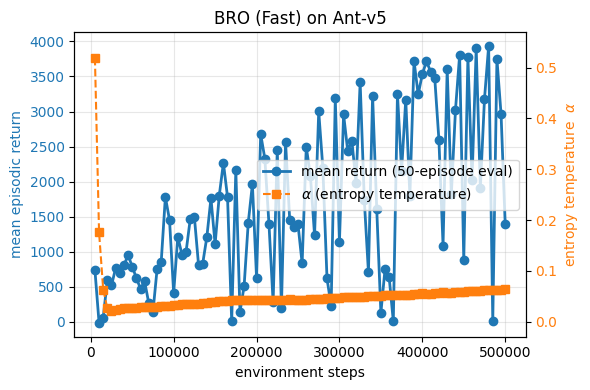

Returns saved to /home/elle/Desktop/COS435/Final_Project/returns_Ant-v5.csv


In [27]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(6,4))

# reward curve
line1 = ax1.plot(
    steps, returns,
    marker='o', lw=2, label=r"mean return (50‑episode eval)"
)
ax1.set_xlabel(r"environment steps")
ax1.set_ylabel(r"mean episodic return", color=line1[0].get_color())
ax1.tick_params(axis='y', labelcolor=line1[0].get_color())
ax1.grid(alpha=.3)

# temperature curve
ax2 = ax1.twinx()
line2 = ax2.plot(
    steps, alpha,
    marker='s', ls='--', color='tab:orange', label=r"$\alpha$ (entropy temperature)"
)

# tighten alpha‑axis limits so its variations are visible
lo, hi = min(alpha), max(alpha)
margin = 0.1 * (hi - lo if hi > lo else 1)
ax2.set_ylim(lo - margin, hi + margin)

ax2.set_ylabel(r"entropy temperature  $\alpha$", color=line2[0].get_color())
ax2.tick_params(axis='y', labelcolor=line2[0].get_color())

# legend and title
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="right")
plt.title(f"BRO (Fast) on {ENV_ID}")
plt.tight_layout()
plt.show()

# save returns as a csv file at the current folder
path = Path.cwd() / f"returns_{ENV_ID}.csv"
np.savetxt(path, np.array(returns), delimiter=",", header="mean episodic return", comments="")
# print the path to the saved file
print(f"Returns saved to {path}")



In [28]:
from gymnasium.wrappers import RecordVideo
env = gym.make(ENV_ID, render_mode="rgb_array")      # no “human” window
vid_env = RecordVideo(env, video_folder="videos",
                      episode_trigger=lambda ep: ep == 0,
                      disable_logger=True)
s,_ = vid_env.reset(seed=SEED)
done = trunc = False
while not (done or trunc):
    s,_,done,trunc,_ = vid_env.step(agent.act(s, eval=True))
vid_env.close()

from IPython.display import Video, HTML
Video(sorted(Path("videos").glob("*.mp4"))[0].as_posix(), embed=True)
